In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy as sp
import os

from skimage import img_as_float
from skimage.morphology import reconstruction, h_maxima, h_minima
from skimage import morphology

In [2]:
# An Unsupervised Approach for Overlapping Cervical Cell Cytoplasm Segmentation

## 1) Cell clump segmentation
### - median filter (5 x 5)
### - adaptive histogram equalization
### - Cytoplasm: OTSU filtering
### - Nucleus: Global-Mean Threshold

## 2) Modified OTSU method with class prior probablility
### - OTSU and class prior probability (pixel * 0.05)

## 3) Cytoplasm segmentation
### - the distance regularized level set evolution

In [3]:
pathdir = '../images/LBC01/'
pathlist = [pathdir + p for p in os.listdir(pathdir)]
pathlist[0:5]

['../images/LBC01/LBC01-20210102(1)_228.png',
 '../images/LBC01/LBC01-20210102(1)_1771.png',
 '../images/LBC01/LBC01-20210102(1)_814.png',
 '../images/LBC01/LBC01-20210102(1)_378.png',
 '../images/LBC01/LBC01-20210102(1)_1268.png']

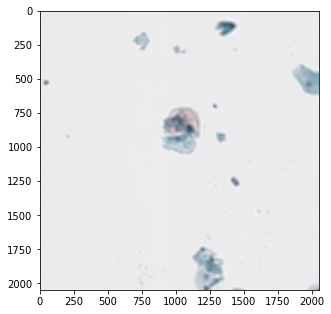

In [146]:
# img = cv2.imread("../../Dataset/papsmear/isbi2015/Training/frame014_stack/fov000.png")
img = cv2.imread(pathlist[102])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 10))
plt.imshow(img);

207.0


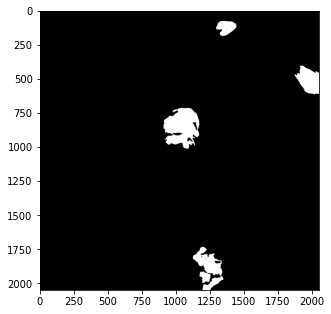

In [147]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, thresh_cv = cv2.threshold(gray_img, -1, 255,  cv2.THRESH_BINARY | cv2.THRESH_OTSU)
gray_img = gray_img > 200
removed_img = morphology.remove_small_objects(~gray_img, min_size=10000)

print(ret)
plt.figure(figsize=(5, 10))
plt.imshow(removed_img, cmap="gray")
plt.show()
# plt.imshow(thresh_cv, cmap="gray")
# plt.show()
# print(gray_img[0][1280])

In [103]:
# # Cell clump segmentation

# ## Median blur
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# sobel = cv2.Sobel(gray_img, cv2.CV_8U, 1, 0, 3)
# laplacian = cv2.Laplacian(gray_img, cv2.CV_8U, ksize=3)
# canny = cv2.Canny(gray_img, 100, 205)
# print(type(canny))
# # cv2.imshow("sobel", sobel)
# # cv2.imshow("laplacian", laplacian)
# # cv2.imshow("canny", canny)
# canny_thres = laplacian > 50
# plt.figure(figsize=(5, 10))
# new_img = gray_img/2.0 + canny/2.0
# new_img = new_img*2.0
# new_img = new_img<200
# new_img = new_img*255
# plt.imshow(new_img);


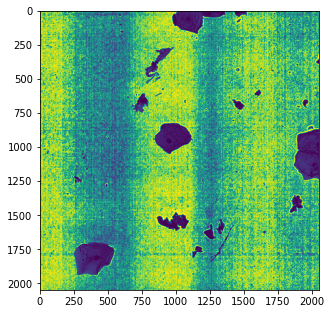

In [104]:
preprocessed_img = cv2.medianBlur(gray_img, 5)
preprocessed_img = cv2.equalizeHist(preprocessed_img)

## Adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
cytoplasm_map = clahe.apply(preprocessed_img)

clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(4,4))
nucleus_map = clahe.apply(preprocessed_img)

plt.figure(figsize=(5, 10))
plt.imshow(nucleus_map);

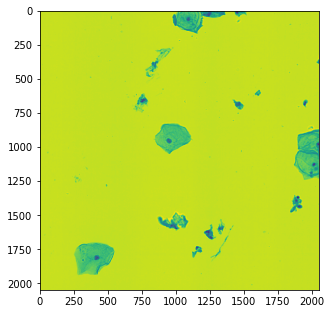

In [32]:
nuc_mask = nucleus_map <= 30
plt.figure(figsize=(5, 10))
plt.imshow(preprocessed_img)

In [33]:
val = filters.threshold_otsu(cytoplasm_map)
cyto_mask = gray_img <= val

plt.figure(figsize=(10, 20))
plt.imshow(cyto_mask)

NameError: name 'filters' is not defined

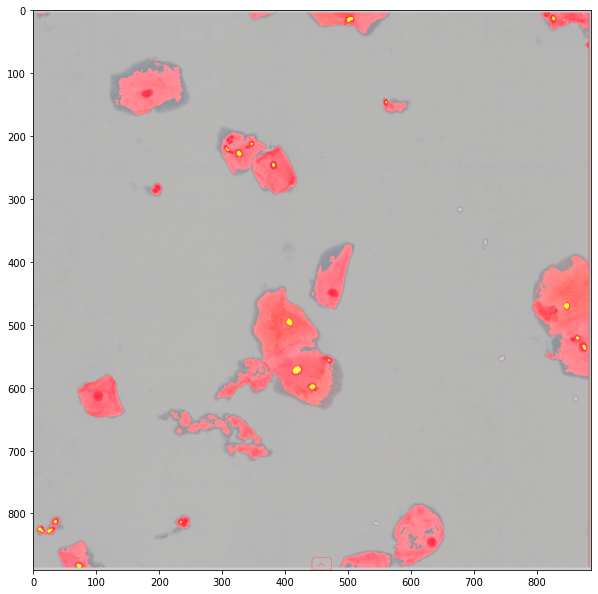

In [471]:
# Overlay
overlay_mask = np.zeros_like(img)
overlay_mask[:,:,0:1] = np.expand_dims(cyto_mask.astype(int) * 255.0, axis=-1)
overlay_mask[:,:,1:2] = np.expand_dims(nuc_mask.astype(int) * 255.0, axis=-1)

overlayed_image = cv2.addWeighted(img, 0.8, overlay_mask, 1.0, 0)

plt.figure(figsize=(10, 20))
plt.imshow(overlayed_image)

In [357]:
# Objective:
# Apply Find-contours to raw image

# Based on loc of maps
## --> 이미지 양 끝에 존재하는 셀들은 생략
## --> cytoplasm map 안에 nucleus map이 존재하지 않는 것들은 생략
## --> 여러개의 핵을 품고 있는 놈들은 생략

# Based on contour size
## --> size가 전체 대비 5% 이상 넘어가면 실제 cell로 인정
## --> check if isolated or not based on crop cell size

### if overlapped cluster cells, apply "DRLSE"
### else, apply weighted "OTSU" filters
